# VNNLib Fuzzing with ACTFuzzer

Inference-based whitebox fuzzing on CIFAR-100 VNNLib benchmarks to find counterexamples.

In [1]:
# Setup and imports
import sys, os
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, act_root) if act_root not in sys.path else None

import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path

# Force reload all fuzzing modules to pick up latest changes
import importlib
modules_to_reload = [
    'act.pipeline.fuzzing.mutations',
    'act.pipeline.fuzzing.coverage',
    'act.pipeline.fuzzing.corpus',
    'act.pipeline.fuzzing.checker',
    'act.pipeline.fuzzing.actfuzzer',
    'act.front_end.model_synthesis',
    'act.front_end.vnnlib_loader.create_specs',
    'act.front_end.vnnlib_loader.vnnlib_parser',
    'act.front_end.vnnlib_loader.onnx_converter',
    'act.front_end.vnnlib_loader.data_model_loader',
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator
from act.front_end.model_synthesis import synthesize_models_from_specs
from act.pipeline.fuzzing.actfuzzer import ACTFuzzer, FuzzingConfig

# CIFAR-100 class names (100 fine-grained classes)
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print("✓ Setup complete (modules reloaded with batch dimension fixes)")


CUDA not available, using CPU
✅ Initialized: device=cpu, dtype=torch.float64
[ACT] Auto-detecting project root: /Users/z3310488/Documents/workspace/ACT
[ACT] Gurobi license found and set: /Users/z3310488/Documents/workspace/ACT/modules/gurobi/gurobi.lic
✓ Setup complete (modules reloaded with batch dimension fixes)


## Load VNNLib Benchmark and Run Fuzzing (1-minute budget)

**Note on VNNLib Property Format:**
- VNNLib benchmarks encode robustness as: `Y_i >= Y_true` for all i ≠ true
- This means: "all wrong classes must have logits ≥ true class logit"
- A **counterexample** (violation) occurs when the model predicts a different class (misclassification)
- The fuzzer tries to find inputs within ε that cause misclassification


In [2]:
print("="*80)
print("LOADING CIFAR-100 VNNLIB BENCHMARK")
print("="*80)

# Load VNNLib instances
creator = VNNLibSpecCreator(config_name="vnnlib_default")
spec_results = creator.create_specs_for_data_model_pairs(
    categories=["cifar100_2024"],
    max_instances=20,  # Load 20 to have selection pool
    validate_shapes=True
)
print(f"✓ Loaded {len(spec_results)} instances\n")

# Randomly select 3 instances for fuzzing
import random
num_seeds = 3
random_indices = random.sample(range(len(spec_results)), min(num_seeds, len(spec_results)))
print(f"🎲 Randomly selected {len(random_indices)} instances: {[i+1 for i in random_indices]}\n")

selected_instances = [spec_results[i] for i in random_indices]

# Synthesize wrapped models for all selected instances
print("Synthesizing wrapped models for selected instances...")
wrapped_models, reports, input_data = synthesize_models_from_specs(selected_instances)
print(f"✓ Models wrapped for {len(wrapped_models)} instances\n")

# Get the first wrapped model (they all use the same architecture)
first_combo_id = list(wrapped_models.keys())[0]
wrapped_model = wrapped_models[first_combo_id]

print(f"Selected Instances for Fuzzing:")
print("-" * 80)
initial_seeds = []
instance_info = []  # Store info for each instance

for idx, (category, instance_id, plain_model, labeled_tensors, spec_pairs) in enumerate(selected_instances):
    input_tensor, true_label = labeled_tensors[0]
    input_spec, output_spec = spec_pairs[0]
    epsilon = float((input_spec.ub - input_spec.lb).max())
    
    print(f"{idx+1}. Model: {category}/{instance_id}")
    print(f"   True label: {true_label} ({CIFAR100_CLASSES[true_label]})")
    print(f"   Epsilon: {epsilon:.6f}")
    
    # Prepare seeds with labeled tensors
    from act.front_end.spec_creator_base import LabeledInputTensor
    for input_tensor_seed, label in labeled_tensors:
        seed = LabeledInputTensor(tensor=input_tensor_seed, label=label)
        initial_seeds.append(seed)
    
    # Store instance info for visualization
    instance_info.append({
        'index': idx,
        'input_tensor': input_tensor,
        'true_label': true_label,
        'epsilon': epsilon,
        'input_spec': input_spec,
        'category': category,
        'instance_id': instance_id
    })

print("-" * 80)
print(f"\n✓ Prepared {len(initial_seeds)} total seeds from {len(selected_instances)} instances\n")

# Load fuzzing config from YAML
config_path = Path(act_root) / "act/pipeline/fuzzing/config.yaml"
with open(config_path) as f:
    yaml_data = yaml.safe_load(f)
    yaml_config = yaml_data['fuzzing']

# Override with 1-minute budget
config = FuzzingConfig(
    max_iterations=yaml_config['max_iterations'],
    timeout_seconds=60.0,  # 1 minute budget
    device="cuda" if torch.cuda.is_available() else "cpu",
    save_counterexamples=yaml_config['save_counterexamples'],
    output_dir=Path("fuzzing_results_vnnlib"),
    report_interval=yaml_config['report_interval'],
    mutation_weights=yaml_config['mutation_weights']
)

print(f"Fuzzing config: timeout={config.timeout_seconds}s, device={config.device}")
print(f"Mutation weights: {config.mutation_weights}\n")

print("="*80)
print("STARTING FUZZING WITH MULTIPLE SEEDS")
print("="*80)

# Run fuzzing with all seeds
fuzzer = ACTFuzzer(
    wrapped_model=wrapped_model,
    initial_seeds=initial_seeds,
    config=config
)
report = fuzzer.fuzz()

print("\n" + "="*80)
print("FUZZING COMPLETE")
print("="*80)
print(f"Iterations: {report.total_iterations} ({report.total_iterations / report.total_time:.1f} it/s)")
print(f"Time: {report.total_time:.2f}s")
print(f"Counterexamples: {len(report.counterexamples)}")
print(f"Coverage: {report.neuron_coverage:.2%}")
print(f"Seeds explored: {report.seeds_explored}")
print("="*80)


LOADING CIFAR-100 VNNLIB BENCHMARK


onnxsim not available, skipping simplification
/Users/z3310488/miniconda3/envs/act-py312/lib/python3.12/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))
onnxsim not available, skipping simplification
/Users/z3310488/miniconda3/envs/act-py312/lib/python3.12/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will r

✓ Loaded 20 instances

🎲 Randomly selected 3 instances: [9, 4, 19]

Synthesizing wrapped models for selected instances...

🧬 Synthesizing models from 3 spec result(s)...
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_1401_sidx_3081_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_8461_sidx_6823_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_3570_sidx_9004_eps_0.0039: Created 1 wrapped model(s)

🎉 Synthesized 3 wrapped models from specs!
✓ Models wrapped for 3 instances

Selected Instances for Fuzzing:
--------------------------------------------------------------------------------
1. Model: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_1401_sidx_3081_eps_0.0039
   True label: 14 (butterfly)
   Epsilon: 0.030590
2. Model: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_8461_sidx_6823_eps_0.00

## Visualize Results


FUZZING SUMMARY
  Iterations: 8309 (138.5 it/s)
  Time: 60.01s
  Seeds explored: 7
  Neuron coverage: 75.04%
  Counterexamples: 0

ORIGINAL INPUTS ANALYSIS
Instance 1: True=butterfly, Pred=butterfly (0.499) ✓ Correct
Instance 2: True=bowl, Pred=bowl (0.381) ✓ Correct
Instance 3: True=caterpillar, Pred=caterpillar (0.311) ✓ Correct

SPECIFICATION SUMMARY

Instance 1 - butterfly:
  InputSpec:
    Kind: BOX
    Shape: torch.Size([3, 32, 32])
    Epsilon (L∞): 0.030590
    Range: [-1.4717, 1.8804]
  VNNLib Property:
    Robustness check: Y_i >= Y_14 for all i ≠ 14
    Meaning: Model should predict 'butterfly' for all inputs within ε=0.030590

Instance 2 - bowl:
  InputSpec:
    Kind: BOX
    Shape: torch.Size([3, 32, 32])
    Epsilon (L∞): 0.030590
    Range: [-1.2418, 2.0250]
  VNNLib Property:
    Robustness check: Y_i >= Y_10 for all i ≠ 10
    Meaning: Model should predict 'bowl' for all inputs within ε=0.030590

Instance 3 - caterpillar:
  InputSpec:
    Kind: BOX
    Shape: torch.Si

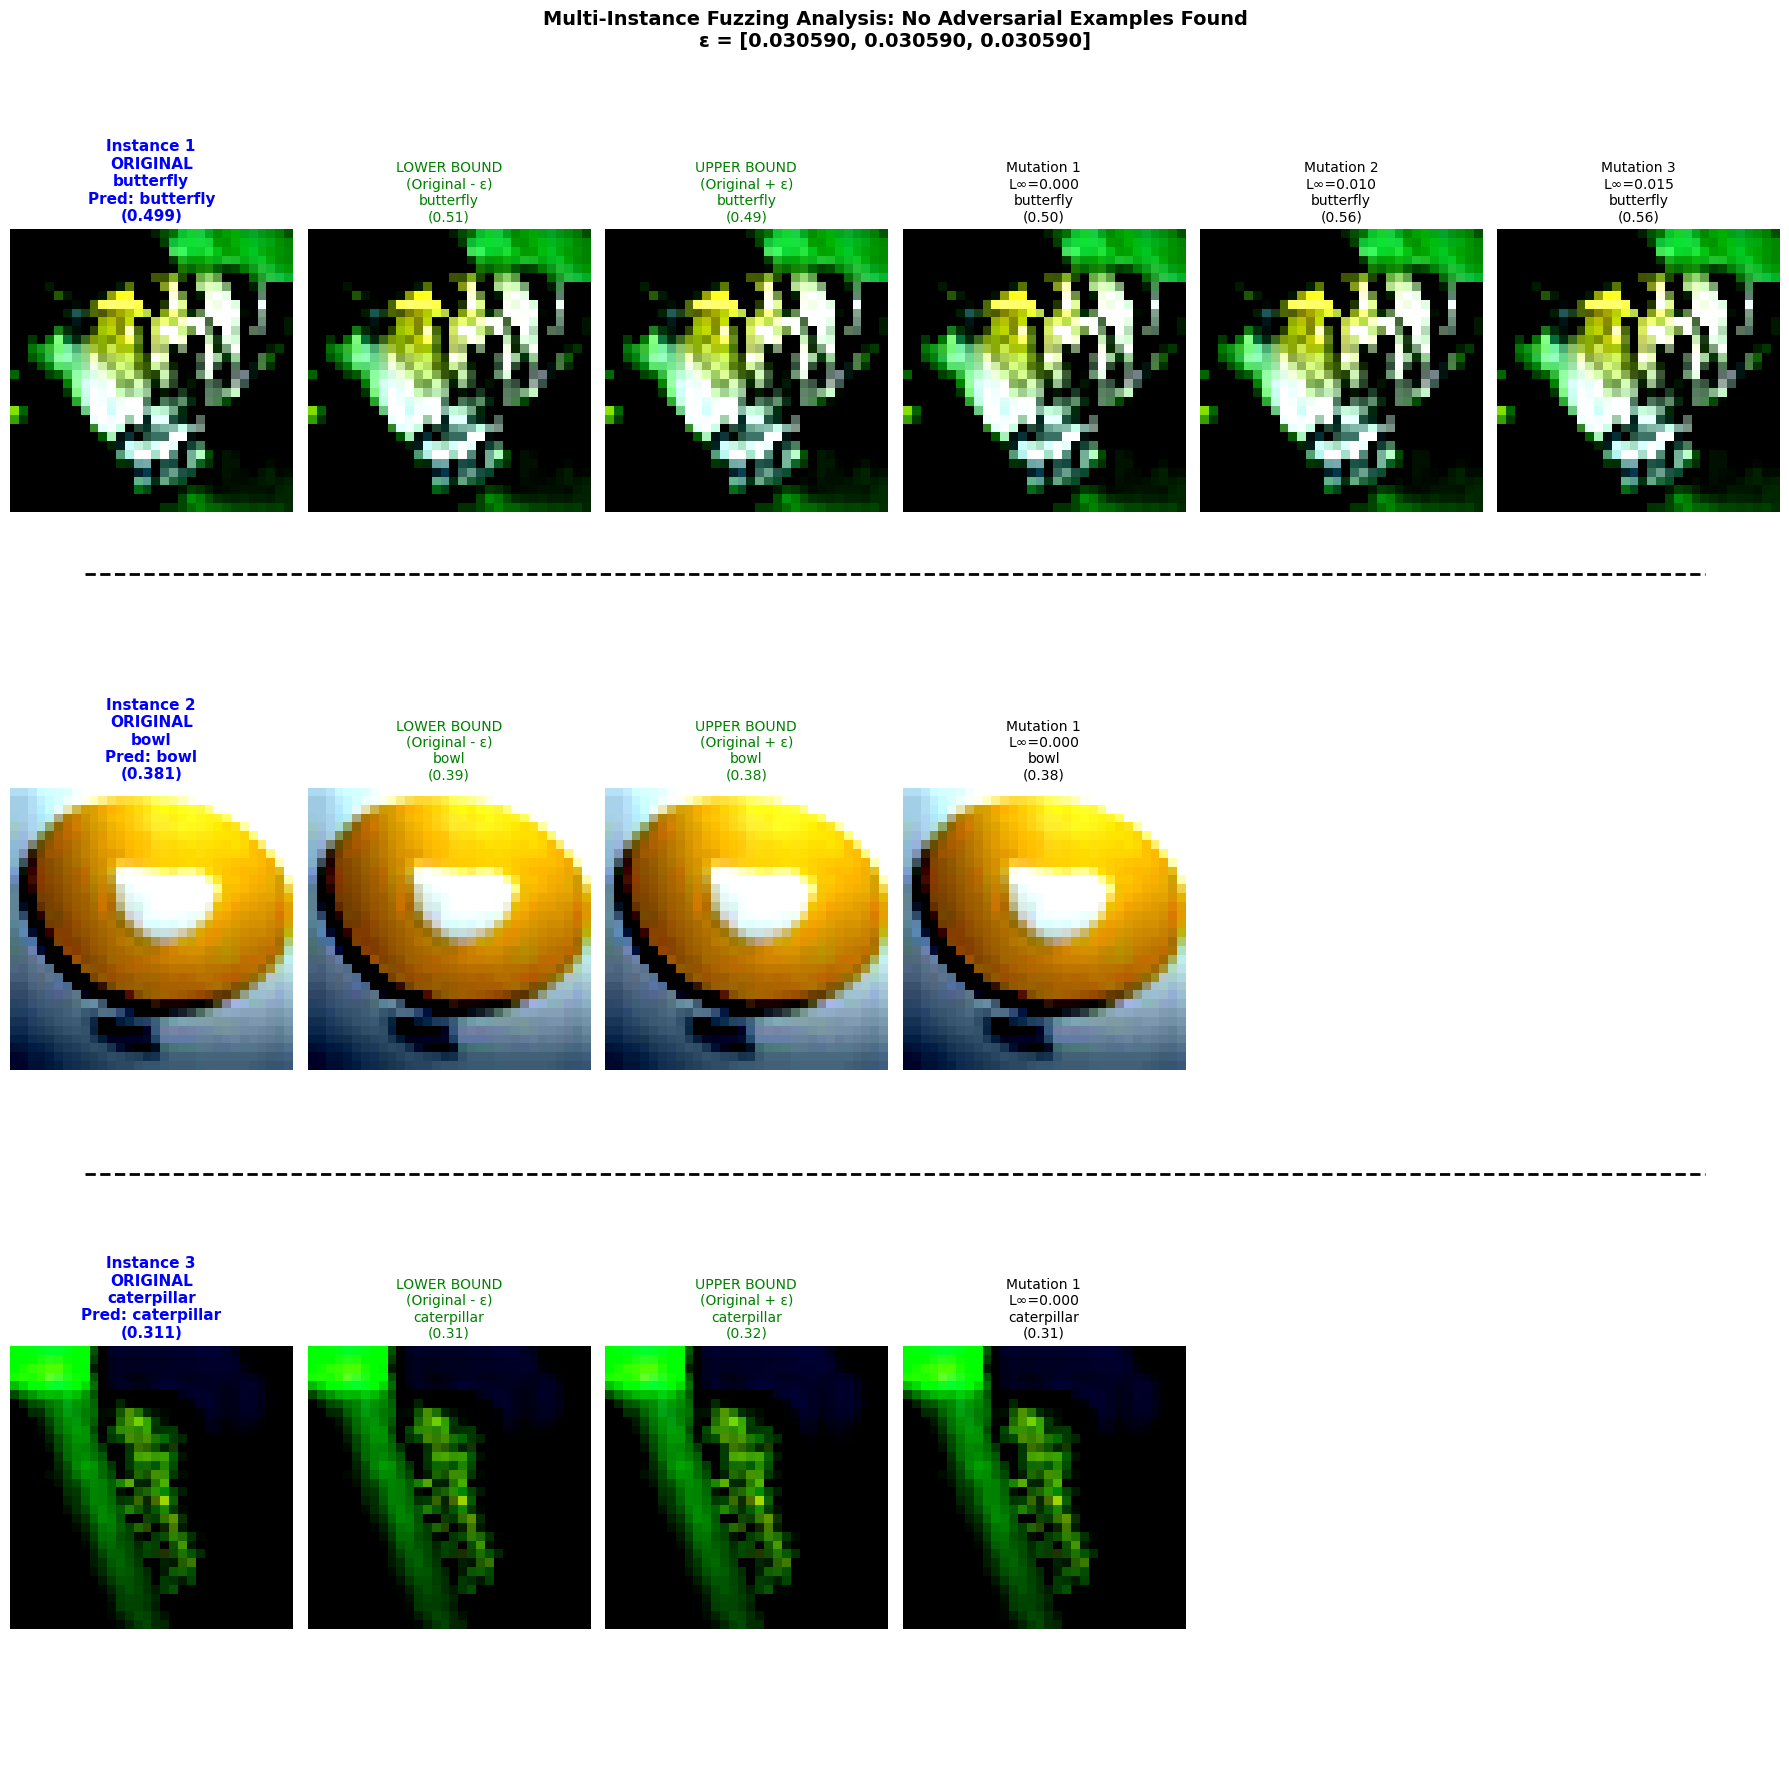


💡 Observations:
  - Tested 3 instances with 7 total perturbation attempts
  - All attempts maintained correct classification for their respective instances
  - Model appears robust for these instances

💡 Suggestions to find counterexamples:
  1. Increase timeout (currently 60.0s)
  2. Try more instances (currently using 3 random instances)
  3. Increase gradient mutation weight (currently 0.4)
  4. Use GPU for faster iterations (currently: cpu)


In [ ]:
# Print fuzzing summary first
print(f"\n{'='*80}")
print(f"FUZZING SUMMARY")
print(f"{'='*80}")
print(f"  Iterations: {report.total_iterations} ({report.total_iterations / report.total_time:.1f} it/s)")
print(f"  Time: {report.total_time:.2f}s")
print(f"  Seeds explored: {report.seeds_explored}")
print(f"  Neuron coverage: {report.neuron_coverage:.2%}")
print(f"  Counterexamples: {len(report.counterexamples)}")
print(f"{'='*80}\n")

# Analyze each instance
print(f"{'='*80}")
print(f"ORIGINAL INPUTS ANALYSIS")
print(f"{'='*80}")

for info in instance_info:
    input_tensor = info['input_tensor']
    true_label = info['true_label']
    
    with torch.no_grad():
        orig_output = wrapped_model(input_tensor.unsqueeze(0))
        if isinstance(orig_output, dict):
            orig_output = orig_output['output']
        orig_pred = orig_output.argmax(dim=1).item()
        orig_probs = torch.softmax(orig_output[0], dim=0)
        orig_conf = orig_probs[orig_pred].item()
    
    status = "✓ Correct" if orig_pred == true_label else "✗ MISCLASSIFIED"
    print(f"Instance {info['index']+1}: True={CIFAR100_CLASSES[true_label]}, "
          f"Pred={CIFAR100_CLASSES[orig_pred]} ({orig_conf:.3f}) {status}")

print(f"{'='*80}\n")

# Print specification summary
print(f"{'='*80}")
print(f"SPECIFICATION SUMMARY")
print(f"{'='*80}")

for info in instance_info:
    input_spec = info['input_spec']
    epsilon = info['epsilon']
    true_label = info['true_label']
    
    print(f"\nInstance {info['index']+1} - {CIFAR100_CLASSES[true_label]}:")
    print(f"  InputSpec:")
    print(f"    Kind: {input_spec.kind}")
    print(f"    Shape: {input_spec.lb.shape}")
    print(f"    Epsilon (L∞): {epsilon:.6f}")
    print(f"    Range: [{input_spec.lb.min():.4f}, {input_spec.ub.max():.4f}]")
    print(f"  VNNLib Property:")
    print(f"    Robustness check: Y_i >= Y_{true_label} for all i ≠ {true_label}")
    print(f"    Meaning: Model should predict '{CIFAR100_CLASSES[true_label]}' for all inputs within ε={epsilon:.6f}")

print(f"\n{'='*80}\n")

# Create comprehensive visualization
if len(report.counterexamples) > 0:
    print(f"{'='*80}")
    print(f"🎯 FOUND {len(report.counterexamples)} COUNTEREXAMPLE(S)!")
    print(f"{'='*80}\n")
    
    # Show counterexample details
    print(f"COUNTEREXAMPLE DETAILS:\n")
    for idx, ce in enumerate(report.counterexamples[:10]):
        print(f"{idx+1}. {ce.kind}: True={CIFAR100_CLASSES[ce.expected]}, "
              f"Predicted={CIFAR100_CLASSES[ce.actual]}, Conf={ce.confidence:.3f}")
    
    # Visualize counterexamples grouped by original instance
    print(f"\n{'='*80}")
    print(f"COUNTEREXAMPLE VISUALIZATION")
    print(f"{'='*80}\n")
    
    num_show = min(10, len(report.counterexamples))
    fig, axes = plt.subplots(num_show, 3, figsize=(12, 4*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Counterexamples Found: Original → Perturbation → Perturbed', 
                 fontsize=14, fontweight='bold')
    
    for idx in range(num_show):
        ce = report.counterexamples[idx]
        
        # Find which instance this counterexample is closest to
        perturbed = ce.input.squeeze()
        if perturbed.dim() == 1:
            perturbed = perturbed.reshape(3, 32, 32)
        
        # Find closest original
        min_dist = float('inf')
        closest_idx = 0
        for i, info in enumerate(instance_info):
            dist = (perturbed - info['input_tensor'].reshape(3, 32, 32)).abs().max()
            if dist < min_dist:
                min_dist = dist
                closest_idx = i
        
        orig_info = instance_info[closest_idx]
        orig_tensor = orig_info['input_tensor'].reshape(3, 32, 32)
        
        # Original image
        orig_img = orig_tensor.permute(1, 2, 0)
        orig_img_np = np.clip(orig_img.cpu().numpy(), 0, 1)
        
        # Perturbed image
        perturbed_img = perturbed.permute(1, 2, 0)
        perturbed_img_np = np.clip(perturbed_img.cpu().numpy(), 0, 1)
        
        # Perturbation (difference)
        diff = perturbed - orig_tensor
        diff_img = diff.permute(1, 2, 0)
        diff_img_np = diff_img.cpu().numpy()
        # Normalize diff for visualization
        diff_vis = (diff_img_np - diff_img_np.min()) / (diff_img_np.max() - diff_img_np.min() + 1e-8)
        
        # Plot original
        axes[idx, 0].imshow(orig_img_np, interpolation='nearest')
        axes[idx, 0].set_title(f'Original (Inst {closest_idx+1})\n{CIFAR100_CLASSES[ce.expected]}', 
                                fontsize=9, color='green', fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Plot perturbation
        axes[idx, 1].imshow(diff_vis, interpolation='nearest')
        l_inf = diff.abs().max().item()
        axes[idx, 1].set_title(f'Perturbation\nL∞={l_inf:.4f}', fontsize=9)
        axes[idx, 1].axis('off')
        
        # Plot perturbed
        axes[idx, 2].imshow(perturbed_img_np, interpolation='nearest')
        axes[idx, 2].set_title(f'Perturbed\n{CIFAR100_CLASSES[ce.actual]}\nConf={ce.confidence:.2f}', 
                                fontsize=9, color='red', fontweight='bold')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Successfully found adversarial examples!")

else:
    print(f"{'='*80}")
    print(f"⚠️  NO COUNTEREXAMPLES FOUND")
    print(f"{'='*80}\n")
    
    print(f"Fuzzing Summary:")
    print(f"  - Iterations: {report.total_iterations}")
    print(f"  - Seeds explored: {report.seeds_explored}")
    print(f"  - Neuron coverage: {report.neuron_coverage:.2%}")
    print(f"  - Time: {report.total_time:.1f}s\n")
    
    # Create visualization: one row per instance with larger images
    print("Creating visualization for all instances...\n")
    
    num_instances = len(instance_info)
    all_corpus_seeds = list(fuzzer.seed_corpus.seeds)
    
    # One row per instance, showing: Original | LB | UB | 3 Attempts
    # Total 6 columns per row
    fig, axes = plt.subplots(num_instances, 6, figsize=(18, 6 * num_instances))
    if num_instances == 1:
        axes = axes.reshape(1, -1)
    
    for inst_idx, info in enumerate(instance_info):
        input_tensor = info['input_tensor']
        true_label = info['true_label']
        input_spec = info['input_spec']
        epsilon = info['epsilon']
        
        # Get prediction on original
        with torch.no_grad():
            orig_output = wrapped_model(input_tensor.unsqueeze(0))
            if isinstance(orig_output, dict):
                orig_output = orig_output['output']
            orig_pred = orig_output.argmax(dim=1).item()
            orig_probs = torch.softmax(orig_output[0], dim=0)
            orig_conf = orig_probs[orig_pred].item()
        
        # Column 0: Original
        orig_img = input_tensor.reshape(3, 32, 32).permute(1, 2, 0)
        orig_img_np = np.clip(orig_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 0].imshow(orig_img_np, interpolation='nearest')
        axes[inst_idx, 0].set_title(f'Instance {inst_idx+1}\nORIGINAL\n{CIFAR100_CLASSES[true_label]}\n'
                                     f'Pred: {CIFAR100_CLASSES[orig_pred]}\n({orig_conf:.3f})',
                                     fontsize=11, color='blue', fontweight='bold')
        axes[inst_idx, 0].axis('off')
        
        # Column 1: Lower Bound
        lb_tensor = input_spec.lb.reshape(3, 32, 32)
        lb_img = lb_tensor.permute(1, 2, 0)
        lb_img_np = np.clip(lb_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 1].imshow(lb_img_np, interpolation='nearest')
        
        with torch.no_grad():
            lb_output = wrapped_model(lb_tensor.unsqueeze(0))
            if isinstance(lb_output, dict):
                lb_output = lb_output['output']
            lb_pred = lb_output.argmax(dim=1).item()
            lb_probs = torch.softmax(lb_output[0], dim=0)
            lb_conf = lb_probs[lb_pred].item()
        
        axes[inst_idx, 1].set_title(f'LOWER BOUND\n(Original - ε)\n{CIFAR100_CLASSES[lb_pred]}\n({lb_conf:.2f})',
                                     fontsize=10, color='red' if lb_pred != true_label else 'green')
        axes[inst_idx, 1].axis('off')
        
        # Column 2: Upper Bound
        ub_tensor = input_spec.ub.reshape(3, 32, 32)
        ub_img = ub_tensor.permute(1, 2, 0)
        ub_img_np = np.clip(ub_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 2].imshow(ub_img_np, interpolation='nearest')
        
        with torch.no_grad():
            ub_output = wrapped_model(ub_tensor.unsqueeze(0))
            if isinstance(ub_output, dict):
                ub_output = ub_output['output']
            ub_pred = ub_output.argmax(dim=1).item()
            ub_probs = torch.softmax(ub_output[0], dim=0)
            ub_conf = ub_probs[ub_pred].item()
        
        axes[inst_idx, 2].set_title(f'UPPER BOUND\n(Original + ε)\n{CIFAR100_CLASSES[ub_pred]}\n({ub_conf:.2f})',
                                     fontsize=10, color='red' if ub_pred != true_label else 'green')
        axes[inst_idx, 2].axis('off')
        
        # Columns 3-5: 3 perturbation attempts closest to this instance
        instance_seeds = []
        for seed in all_corpus_seeds:
            seed_tensor = seed.tensor.reshape(3, 32, 32)
            dist = (seed_tensor - input_tensor.reshape(3, 32, 32)).abs().max().item()
            if dist <= epsilon * 2:  # Within reasonable range
                instance_seeds.append((seed, dist))
        
        # Sort by distance and take closest 3
        instance_seeds.sort(key=lambda x: x[1])
        instance_seeds = instance_seeds[:3]
        
        for seed_idx, (seed, dist) in enumerate(instance_seeds):
            col = 3 + seed_idx
            
            seed_tensor = seed.tensor.reshape(3, 32, 32)
            img = seed_tensor.permute(1, 2, 0)
            img_np = np.clip(img.cpu().numpy(), 0, 1)
            
            # Compute perturbation from this instance's original
            diff = seed_tensor - input_tensor.reshape(3, 32, 32)
            l_inf = diff.abs().max().item()
            
            # Get prediction
            with torch.no_grad():
                seed_output = wrapped_model(seed_tensor.unsqueeze(0))
                if isinstance(seed_output, dict):
                    seed_output = seed_output['output']
                seed_pred = seed_output.argmax(dim=1).item()
                seed_probs = torch.softmax(seed_output[0], dim=0)
                seed_conf = seed_probs[seed_pred].item()
            
            axes[inst_idx, col].imshow(img_np, interpolation='nearest')
            title_color = 'red' if seed_pred != true_label else 'black'
            axes[inst_idx, col].set_title(f'Mutation {seed_idx+1}\nL∞={l_inf:.3f}\n'
                                          f'{CIFAR100_CLASSES[seed_pred]}\n({seed_conf:.2f})',
                                          fontsize=10, color=title_color, fontweight='bold' if seed_pred != true_label else 'normal')
            axes[inst_idx, col].axis('off')
        
        # Fill empty columns if less than 3 attempts
        for empty_col in range(3 + len(instance_seeds), 6):
            axes[inst_idx, empty_col].axis('off')
    
    # Add horizontal dash lines between rows
    for inst_idx in range(num_instances - 1):
        line_y = (inst_idx + 1) / num_instances
        fig.add_artist(plt.Line2D([0.05, 0.95], [line_y, line_y],
                                   transform=fig.transFigure, 
                                   color='black', linewidth=2, linestyle='--'))
    
    # Add epsilon annotation to title
    epsilon_list = [f"{info['epsilon']:.6f}" for info in instance_info]
    epsilon_str = f"ε = [{', '.join(epsilon_list)}]"
    plt.suptitle(f'Multi-Instance Fuzzing Analysis: No Adversarial Examples Found\n{epsilon_str}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    print(f"\n💡 Observations:")
    print(f"  - Tested {len(instance_info)} instances with {len(all_corpus_seeds)} total perturbation attempts")
    print(f"  - All attempts maintained correct classification for their respective instances")
    print(f"  - Model appears robust for these instances")
    print(f"\n💡 Suggestions to find counterexamples:")
    print(f"  1. Increase timeout (currently {config.timeout_seconds}s)")
    print(f"  2. Try more instances (currently using {len(instance_info)} random instances)")
    print(f"  3. Increase gradient mutation weight (currently {config.mutation_weights.get('gradient', 0)})")
    print(f"  4. Use GPU for faster iterations (currently: {config.device})")
